# Trabajo Práctico 1: Reservas de Hotel
En esta primera etapa del tp buscaremos hacer un analisis en profundidad de los datos del dataset "Hotels_train".




In [1]:
import math
import numpy as np 
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Preparacion del Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_hotels_train = pd.read_csv('drive/MyDrive/hotels_train.csv')

Mostramos las primeras 5 columans del dataset

In [4]:
df_hotels_train.head(5)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,NaN,0,Transient,229.0,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,NaN,0,Transient,75.0,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,NaN,0,Transient-Party,75.0,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0


El dataset tiene 33 columnas y 61913 filas

Observamos los tipos de datos que contienen nuestras columnas

In [5]:
#Eliminamos las columnas de reservation_status y reservation_status_date para evitar confusiones
df_hotels_train = df_hotels_train.drop(['reservation_status','reservation_status_date'], axis =1) #->Desmarcar al abrir el archivo
df_hotels_train.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

Como los datos del tipo object dificultan realizar graficos y usar algunas funciones de colab, vamos a definir un tipo de dato para cada uno

In [6]:
df_hotels_train['hotel'] = df_hotels_train['hotel'].astype('string')
df_hotels_train['arrival_date_month'] = df_hotels_train['arrival_date_month'].astype('string')
df_hotels_train['meal'] = df_hotels_train['meal'].astype('string')
df_hotels_train['country'] = df_hotels_train['country'].astype('string')
df_hotels_train['id'] = df_hotels_train['id'].astype('string')
df_hotels_train['customer_type'] = df_hotels_train['customer_type'].astype('string')
df_hotels_train['market_segment'] = df_hotels_train['market_segment'].astype('string')
df_hotels_train['distribution_channel'] = df_hotels_train['distribution_channel'].astype('string')
df_hotels_train['reserved_room_type'] = df_hotels_train['reserved_room_type'].astype('string')
df_hotels_train['assigned_room_type'] = df_hotels_train['assigned_room_type'].astype('string')
df_hotels_train['deposit_type'] = df_hotels_train['deposit_type'].astype('string')


##Variables cuantitativas

Definimos las variables cuantitativas y armamos un dataset aparte para facilitar el uso de dichas variables.
Dichas variables son: 


*   adults
*   children
*   babies
*   previos_cancellation
*   previous_booking_not_canceled
*   booking_changes
*   adr
*   total_of_special_requests
*   lead_time
*   arrival_date_week_number
*   arrival_date_day_of_month
*   stays_in_weekend_nights
*   stays_in_week_nights
*   days_in_waiting_list
*   arrival_date_year
*   reservation_status_date








Definimos un dataset con las variables cualitatativas para usar mas adelante

In [7]:
lista_cuantitativas = ['adults','children', 'babies','previous_cancellations','previous_bookings_not_canceled','booking_changes','adr','total_of_special_requests',  'lead_time','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights', 'days_in_waiting_list', 'arrival_date_year']
df_cuantitativas = df_hotels_train[lista_cuantitativas].squeeze() #Primero separamos las cuantitvas

Mostramos media, moda y mediana

In [8]:
df_cuantitativas.mean()

adults                               1.862791
children                             0.104896
babies                               0.007155
previous_cancellations               0.114790
previous_bookings_not_canceled       0.115420
booking_changes                      0.195952
adr                                102.383773
total_of_special_requests            0.523703
lead_time                          112.248187
arrival_date_week_number            27.218080
arrival_date_day_of_month           15.785812
stays_in_weekend_nights              0.924135
stays_in_week_nights                 2.510054
days_in_waiting_list                 2.638977
arrival_date_year                 2016.154749
dtype: float64

In [9]:
df_cuantitativas.mode().squeeze()

adults                               2.0
children                             0.0
babies                               0.0
previous_cancellations               0.0
previous_bookings_not_canceled       0.0
booking_changes                      0.0
adr                                 62.0
total_of_special_requests            0.0
lead_time                            0.0
arrival_date_week_number            33.0
arrival_date_day_of_month           17.0
stays_in_weekend_nights              0.0
stays_in_week_nights                 2.0
days_in_waiting_list                 0.0
arrival_date_year                 2016.0
Name: 0, dtype: float64

In [10]:
df_cuantitativas.median()

adults                               2.0
children                             0.0
babies                               0.0
previous_cancellations               0.0
previous_bookings_not_canceled       0.0
booking_changes                      0.0
adr                                 95.0
total_of_special_requests            0.0
lead_time                           78.0
arrival_date_week_number            28.0
arrival_date_day_of_month           16.0
stays_in_weekend_nights              1.0
stays_in_week_nights                 2.0
days_in_waiting_list                 0.0
arrival_date_year                 2016.0
dtype: float64

## Variables cualitativas
Haremos los mismos que con las variables cuantitativas.
Nuestras variables cualitativas son:


*   hotel
*   arrival_date_month
*   meal
*   country
*   market_segment
*   distribution_channel
*   is_reapeated_guest
*   reserved_room_type
*   assigned_room_type
*   deposit_type
*   agent
*   company
*   customer_type
*   required_car_parking_spaces
*   id
*   is_canceled







In [11]:
df_cualitativas = df_hotels_train.drop(lista_cuantitativas, axis=1).squeeze()

Definimos un dataset con las variables cuantitativas para usar mas adelante

Mostramos los posibles valores de las variables cualitativas y cada cuanto los toman

In [12]:
for c in df_cuantitativas.columns:
    print("----"+c+"---")
    print(df_cuantitativas[c].value_counts())
    print()

----adults---
2     46962
1     11549
3      3164
0       197
4        30
26        3
5         2
40        1
20        1
6         1
10        1
27        1
55        1
Name: adults, dtype: int64

----children---
0.0     57457
1.0      2457
2.0      1955
3.0        39
10.0        1
Name: children, dtype: int64

----babies---
0    61485
1      420
2        7
9        1
Name: babies, dtype: int64

----previous_cancellations---
0     57519
1      4137
2        61
24       36
3        34
26       20
19       17
4        16
25       16
11       15
14       12
6        12
5         9
13        8
21        1
Name: previous_cancellations, dtype: int64

----previous_bookings_not_canceled---
0     60375
1       631
2       258
3       151
4       103
5        79
6        44
8        29
7        29
10       24
9        23
11       21
13       19
12       14
14       12
25       10
15        9
17        8
18        7
24        6
20        5
22        5
26        5
16        4
19        4
28      

**Variables que no son relevantes para el analisis** 

Con la informacion que tenemos hasta ahora, diremos que las vars que no tomaremos en el analisis seran: id (ya que no nos da ninguna certeza con los valores que toma), reservation_status y reservation_status_date (ya que tampoco aportaran nada a nuestro analisis).


##Analisis de correlacion y graficos de distribucion de las variables

*Distribucion de datos*

In [13]:
def crear_bar_plot(df, x, y, label ):

    plt.figure(dpi=140)
    sns.set_style("whitegrid")
    ax = sns.barplot(x=x, y=y, data=df ,alpha= 0.8, orient='v')
    ax.set_title(label)
    ax.set_xlabel(x)
    ax.set_ylabel('Cantidad')
    if len(df) > 5:

        plt.xticks(rotation=90)

    plt.show()





Distribucion de las variables

Vamos a mostrar algunas distribuciones de las variables (mostraremos siempre el top 25 por comodidad).
Vamos a tratar de mostrar la distribucion de nuestras principales varaibles de analisis, empezando por las cualitativas y luego las cuantitativas.

In [14]:
#Countrys
data_paises = df_hotels_train[['country']].groupby(['country'])['country'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_paises.columns = ['Pais','Cantidad']


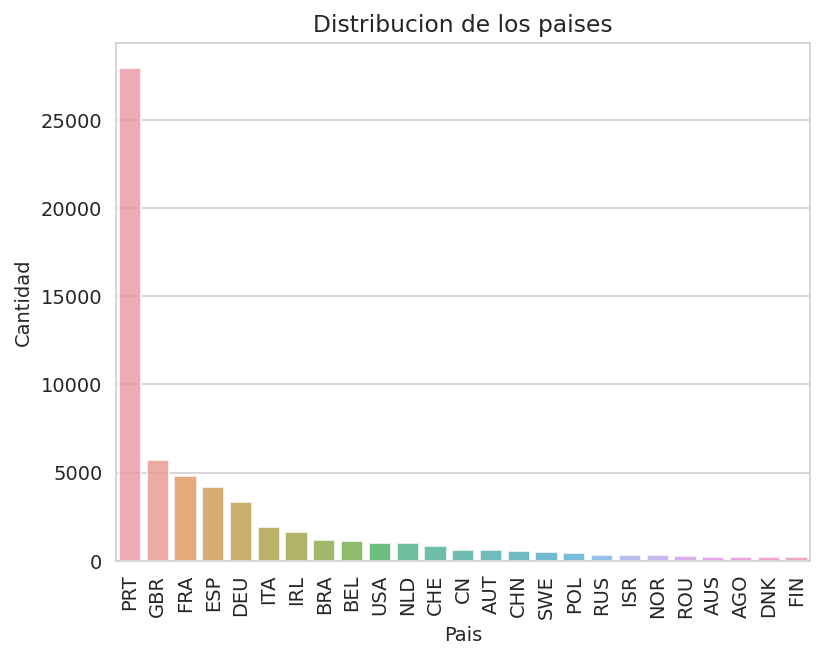

In [15]:
crear_bar_plot(data_paises.head(25),'Pais','Cantidad','Distribucion de los paises')

In [16]:
data_agentes = df_hotels_train[['agent']].groupby(['agent'])['agent'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_agentes.columns = ['Agente','Cantidad']


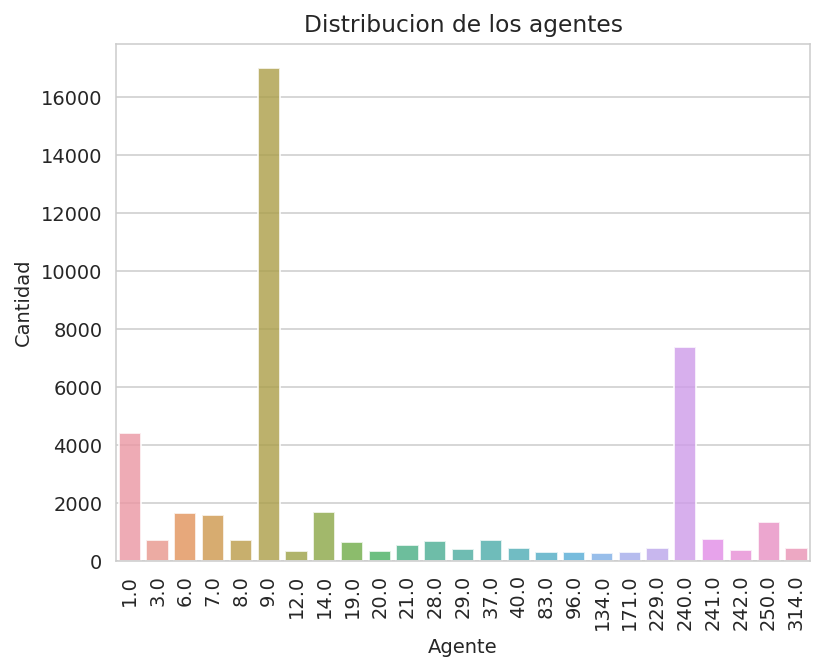

In [17]:
crear_bar_plot(data_agentes.head(25),'Agente','Cantidad','Distribucion de los agentes')

In [18]:
data_depositos = df_hotels_train[['deposit_type']].groupby(['deposit_type'])['deposit_type'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_depositos.columns = ['Deposito','Cantidad']

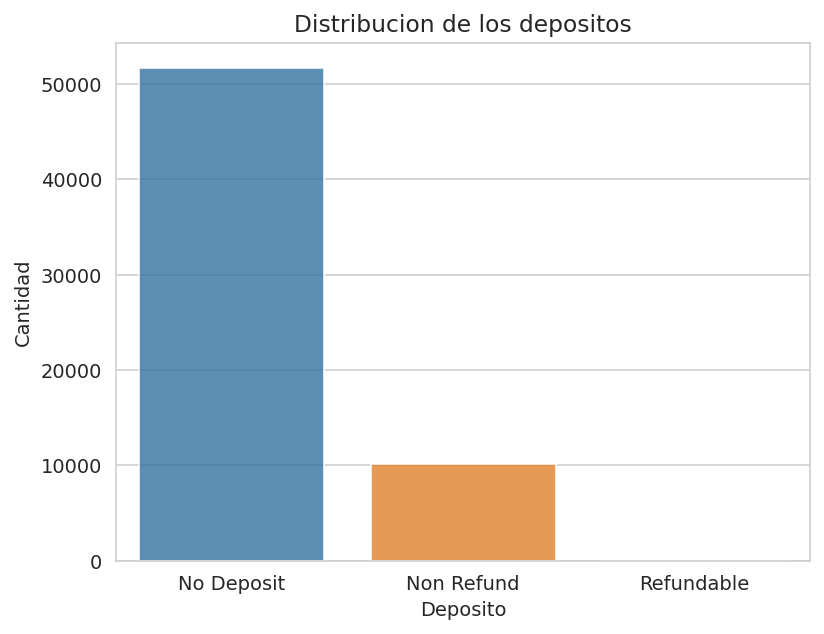

In [19]:
crear_bar_plot(data_depositos.head(25),'Deposito','Cantidad','Distribucion de los depositos')

In [20]:
data_chicos = df_hotels_train[['children']].groupby(['children'])['children'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_chicos.columns = ['Chicos','Cantidad']

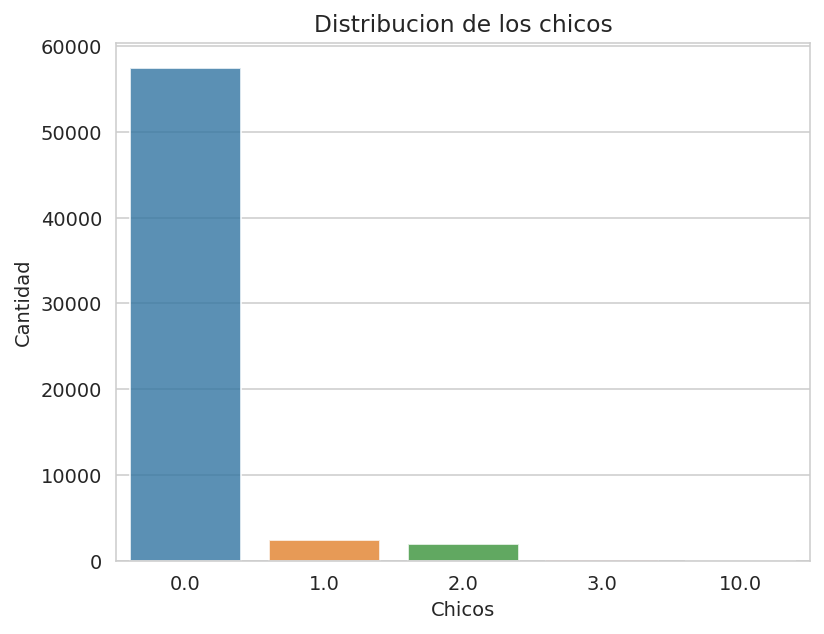

In [21]:
crear_bar_plot(data_chicos.head(25),'Chicos','Cantidad','Distribucion de los chicos')

In [22]:
data_hotel = df_hotels_train[['hotel']].groupby(['hotel'])['hotel'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_hotel.columns = ['Hotel','Cantidad']

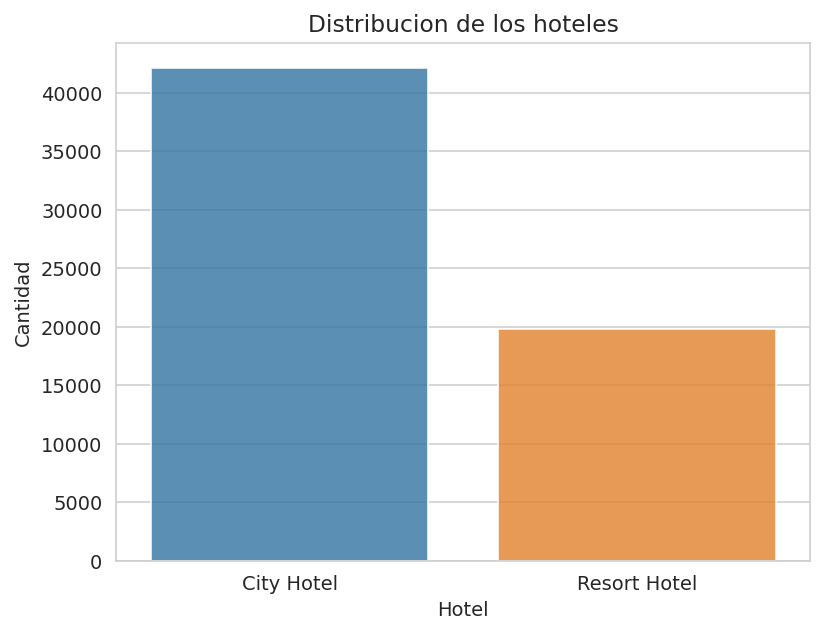

In [23]:
crear_bar_plot(data_hotel.head(25),'Hotel','Cantidad','Distribucion de los hoteles')

In [24]:
data_reservas = df_hotels_train[['reserved_room_type']].groupby(['reserved_room_type'])['reserved_room_type'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_reservas.columns = ['Reserva','Cantidad']

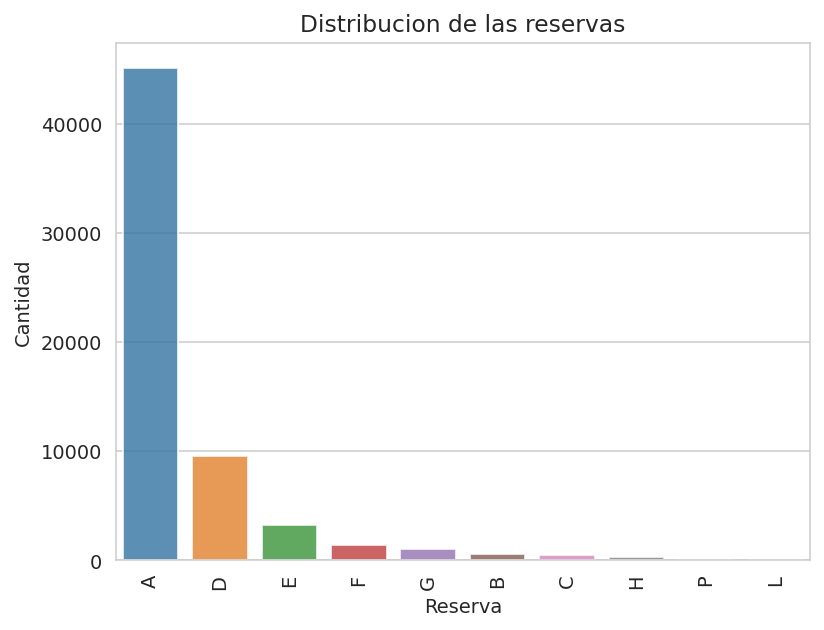

In [25]:
crear_bar_plot(data_reservas.head(25),'Reserva','Cantidad','Distribucion de las reservas')

Variables como id no vale la pena graficarlas, debido a que no representan nada util para el analisis (como ya discutimos antes) por otro lado, nuestra varialble target 'is_canceled' tiene un analisis de su distribucion mas adelante.
Ademas tenemos muchas otras variables cualitativas que podrian importarnos, por el momento supondremos que esta son las variables que mas nos ayudaran en el analisis (Podriamos graficar directamente todas las variables, pero no nos parece lo adecuado).

Distribucion de variables cuantitativas

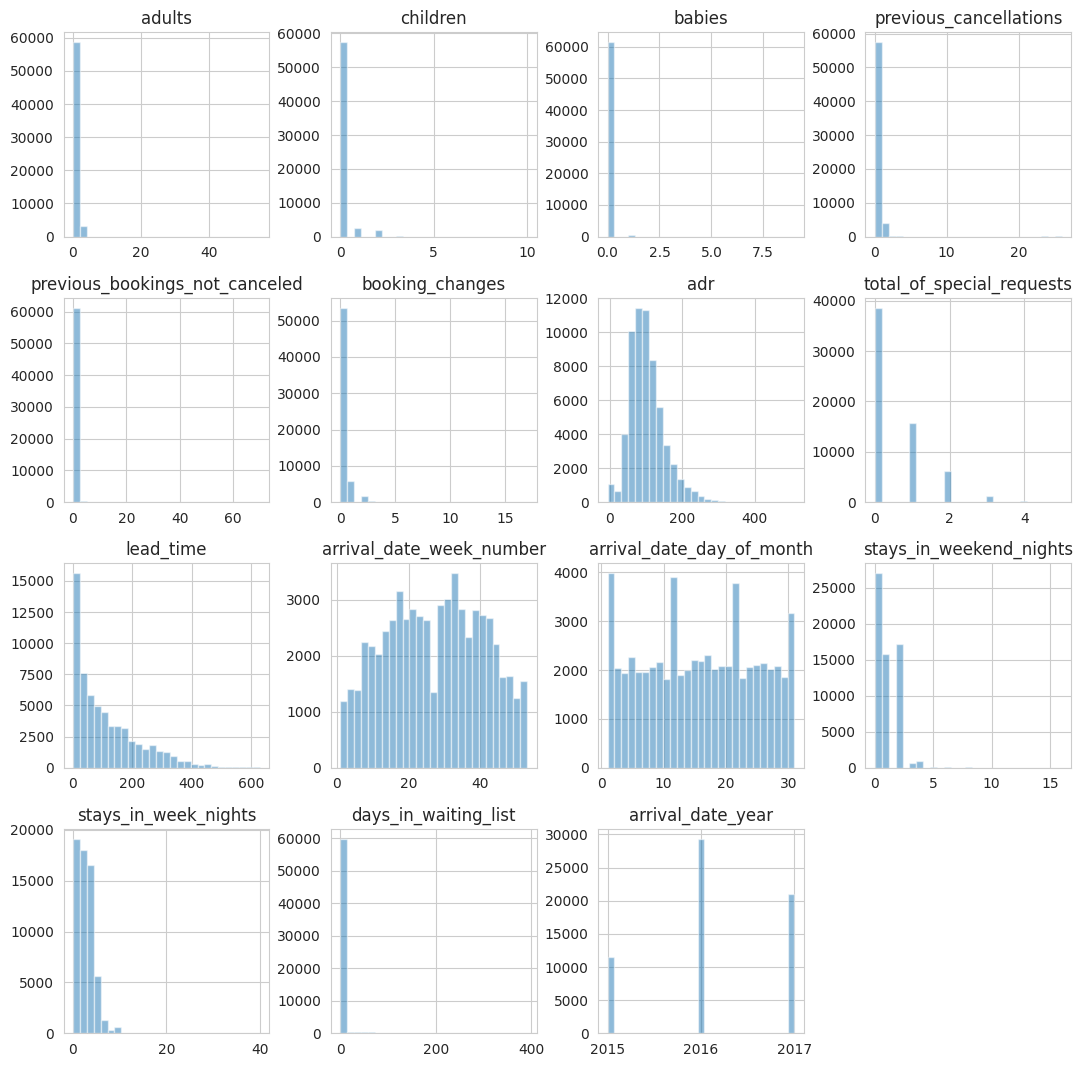

In [26]:
df_hist = df_cuantitativas.hist(figsize=(13,13), bins=27, alpha = 0.5)

En este grafico podemos ver como estan distribuidas las variables cuantitativas

Analisis de la correlacion entre variables

In [27]:
correlacion_todas = df_hotels_train.corr()
display(correlacion_todas)


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
lead_time,1.000000,0.023186,0.134793,-0.006937,0.059463,0.140110,0.110942,-0.046058,-0.022872,-0.108033,0.094634,-0.068102,-0.019736,-0.078786,0.150773,0.166423,-0.094559,-0.113772,-0.122760,0.293816
arrival_date_year,0.023186,1.000000,-0.540542,0.002326,0.027066,0.040803,0.026576,0.059412,-0.013745,-0.004587,-0.142232,0.027109,0.027285,0.081634,0.243066,-0.058523,0.217409,-0.011620,0.107899,0.019923
arrival_date_week_number,0.134793,-0.540542,1.000000,0.057730,0.014127,0.012200,0.025886,0.006355,0.016215,-0.022037,0.045530,-0.023897,0.012086,-0.043968,-0.040886,0.019328,0.075427,0.001424,0.029283,0.008357
arrival_date_day_of_month,-0.006937,0.002326,0.057730,1.000000,-0.015518,-0.026449,0.002449,0.013991,0.002568,-0.005230,-0.034516,-0.002026,0.009522,0.002600,0.049011,0.027754,0.033695,0.000295,0.007744,-0.007371
stays_in_weekend_nights,0.059463,0.027066,0.014127,-0.015518,1.000000,0.488710,0.083397,0.051987,0.021991,-0.080412,-0.011110,-0.037958,0.043753,0.150907,0.066591,-0.057509,0.061136,-0.014228,0.072150,0.001279
stays_in_week_nights,0.140110,0.040803,0.012200,-0.026449,0.488710,1.000000,0.087992,0.058278,0.021390,-0.088363,-0.013417,-0.045190,0.070094,0.197293,0.211214,-0.004139,0.082910,-0.021657,0.073356,0.028439
adults,0.110942,0.026576,0.025886,0.002449,0.083397,0.087992,1.000000,0.029215,0.014812,-0.129198,-0.003197,-0.096896,-0.045378,-0.030557,0.181019,-0.009420,0.221538,0.010593,0.107599,0.060179
children,-0.046058,0.059412,0.006355,0.013991,0.051987,0.058278,0.029215,1.000000,0.028946,-0.029847,-0.027296,-0.019686,0.058871,0.056140,0.033754,-0.035480,0.350482,0.045272,0.080017,0.006242
babies,-0.022872,-0.013745,0.016215,0.002568,0.021991,0.021390,0.014812,0.028946,1.000000,-0.008925,-0.007734,-0.005790,0.088186,0.036594,0.026146,-0.010863,0.033735,0.036372,0.093348,-0.032034
is_repeated_guest,-0.108033,-0.004587,-0.022037,-0.005230,-0.080412,-0.088363,-0.129198,-0.029847,-0.008925,1.000000,0.075981,0.406030,0.008407,0.018729,-0.233782,-0.021828,-0.132263,0.073732,0.015965,-0.090492


En esta tabla podemos ver que hay varias variables que estan fuertemente o debilmente correlacionadas, tambien haremos un analisis con nuestra variable target, por lo tanto veremos los graficos en el siguiente punto

Analisimos el target con el resto de las variables

In [28]:
#Recalco que para ver las correlacion las varaibles deben ser del tipo numerica
correlations = df_hotels_train.corr()['is_canceled']
display(correlations)

lead_time                         0.293816
arrival_date_year                 0.019923
arrival_date_week_number          0.008357
arrival_date_day_of_month        -0.007371
stays_in_weekend_nights           0.001279
stays_in_week_nights              0.028439
adults                            0.060179
children                          0.006242
babies                           -0.032034
is_repeated_guest                -0.090492
previous_cancellations            0.099613
previous_bookings_not_canceled   -0.065868
booking_changes                  -0.159315
agent                            -0.086176
company                          -0.040010
days_in_waiting_list              0.050827
adr                               0.049206
required_car_parking_spaces      -0.225915
total_of_special_requests        -0.244997
is_canceled                       1.000000
Name: is_canceled, dtype: float64

Realizaremos dos graficos para el analisis de las correlaciones con nuestras variable, separandolos en "positivas" y "negativas"

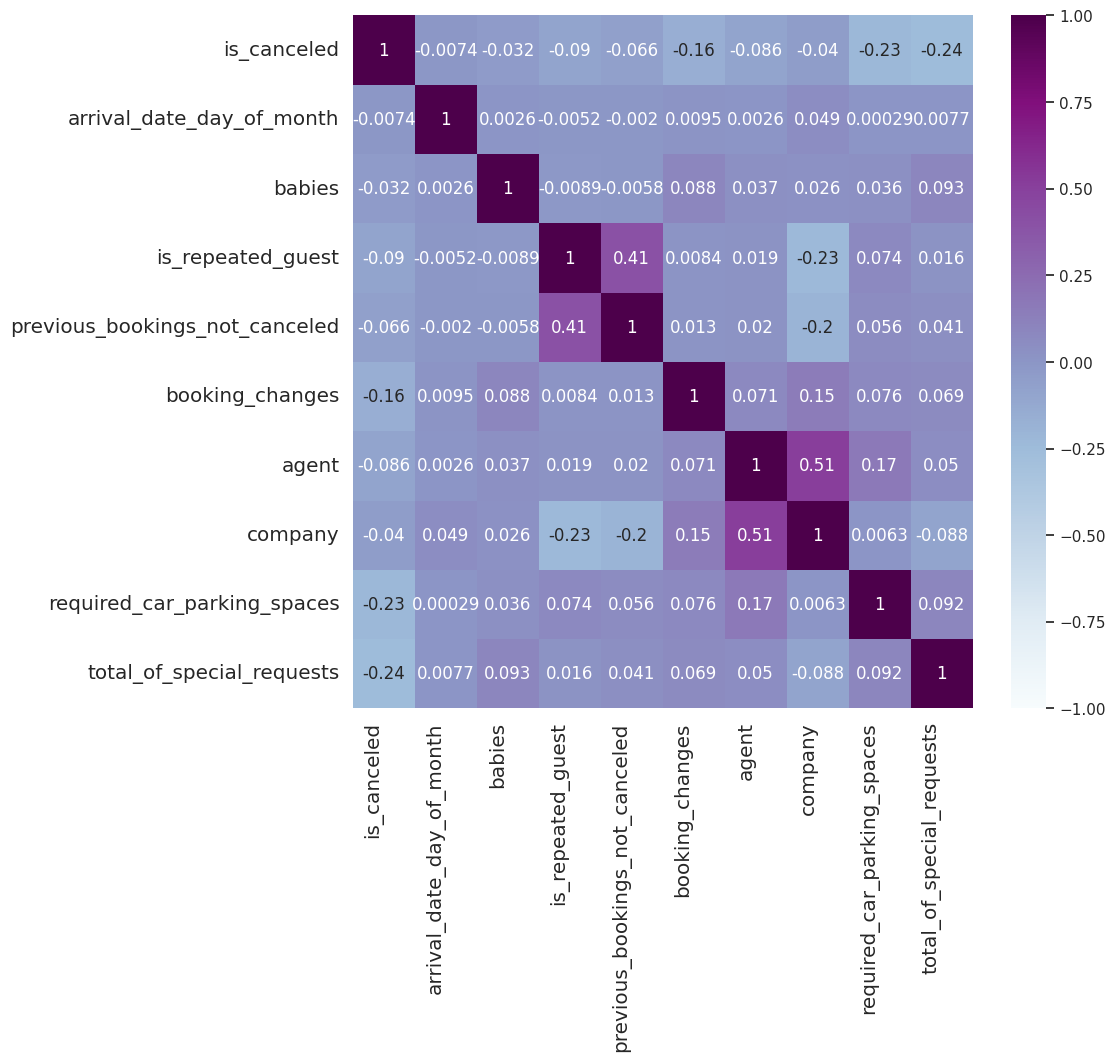

In [29]:
lista_corr_negativas = ['is_canceled','arrival_date_day_of_month','babies','is_repeated_guest','previous_bookings_not_canceled','booking_changes','agent','company','required_car_parking_spaces','total_of_special_requests']
corr_matrix = df_hotels_train[lista_corr_negativas].corr() 
sns.set(rc = {'figure.figsize':(10,9)})
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="BuPu")
heatmap.set_xticklabels(
    
    heatmap.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'
)

heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontweight='light',
    fontsize='large'
)



plt.show()

Vemos que las variables que tiene la correlacion "negativa" mas alta son required_card_parking_space ,total_of_spaces_request y booking_changed. Luego tenemos otras que tienen una menor relacion con nuestra variable target como arrival_date_day_of_month (la cual es casi 0)

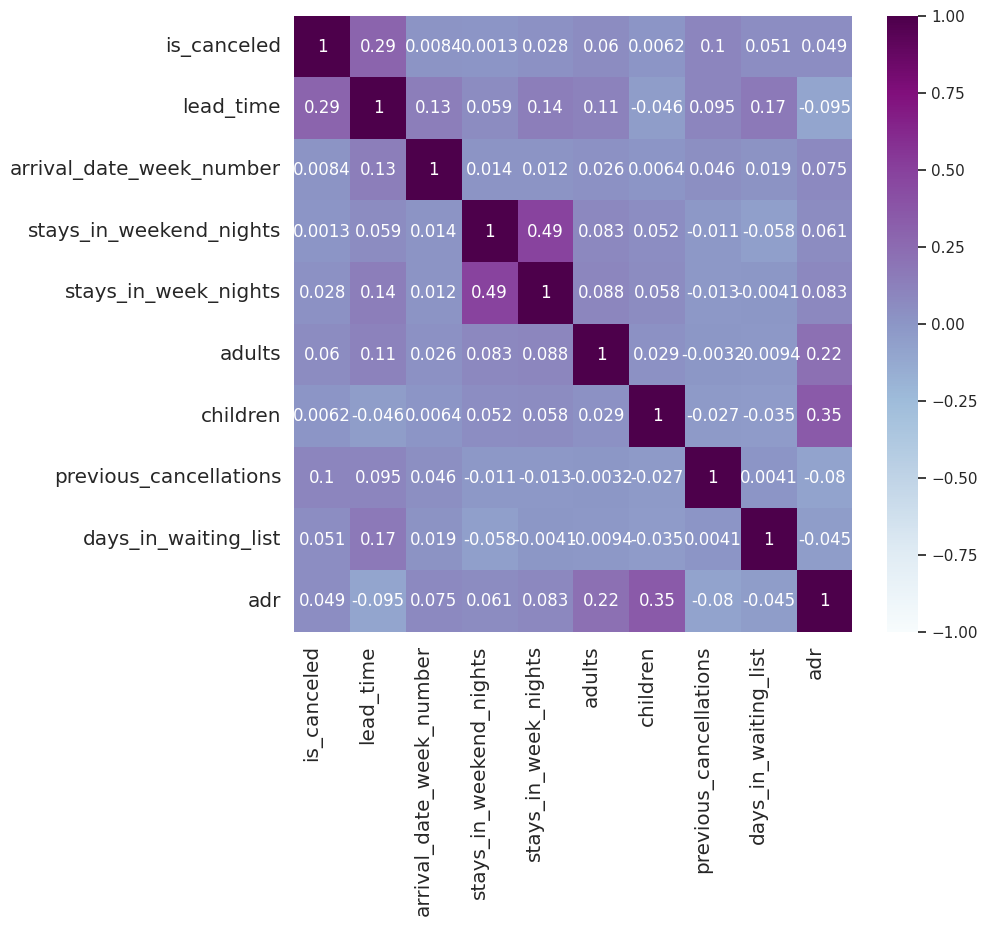

In [30]:


lista_corr_positiva = ['is_canceled','lead_time','arrival_date_week_number','stays_in_weekend_nights','stays_in_week_nights','adults','children','previous_cancellations','days_in_waiting_list','adr',]
corr_matrix = df_hotels_train[lista_corr_positiva].corr()
sns.set(rc = {'figure.figsize':(9,8)})
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="BuPu")
heatmap.set_xticklabels(
    
    heatmap.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'
)

heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontweight='light',
    fontsize='large'
)



plt.show()

Podemos ver que las variables que tienen una relacion "positiva" mas alta con nuestro target son lead_time y previos cancelation.
Luego, tenemos algunas variables que tambien tienen un correlacion considerable como adults (la cual, es bastante baja).
El resto de las variables tiene una correlacion muy baja con nuestra variable target

Como punto final, podemos tambien analizar la correlacion entre todas nuestras variables. ademas de nuestra variable target y ver si sus correlacion son fuertes o debiles

## Visualización de los datos

Como primera visualizacion de nuestros datos empezaremos por nuestra variable target (is_caceled)

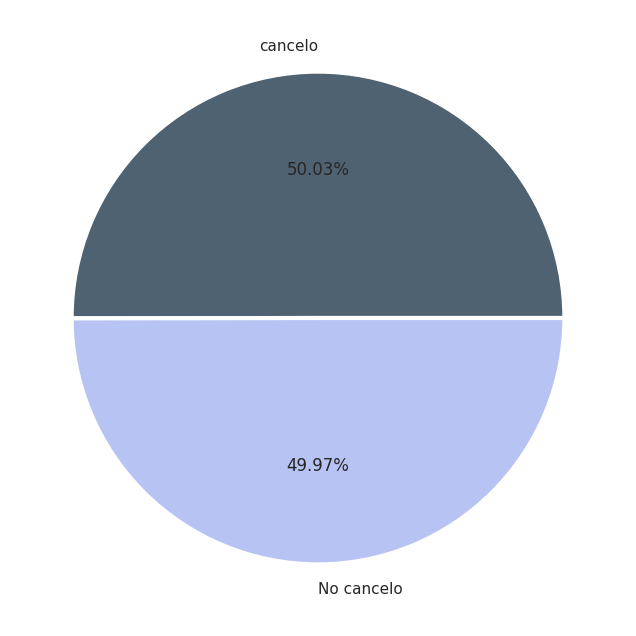

In [31]:
cancelaciones = df_hotels_train['is_canceled'].value_counts()
colores = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
nombres = 'cancelo','No cancelo'
plt.pie(cancelaciones, labels = nombres, labeldistance=1.1, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = colores, autopct = '%1.2f%%')
plt.show()

Como primer analisis vemos que tenemos un 50.03% de reservas canceladas y un 49.97% que no.

Como siguiente visualizacion, haremos un grafico para ver la dispersion de nuestros datos.
Trataremos de graficar las dispersiones que consideremos mas importantes

In [32]:
def create_scatter(df, col1, col2, col3, sample_pct=1):
    sample_size = math.ceil(sample_pct * df.shape[0])
    fig, ax = plt.subplots()
    for t, data in df[[col1, col2, col3]].sample(sample_size).groupby(col3):
      ax.scatter(data[col1], data[col2], label=t, alpha=0.3)

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    plt.show()

def create_xtab_barplot(df, col1, col2, figsize=(6,4), sample_pct=1):
    sample_size = math.ceil(sample_pct * df.shape[0])
    pd.crosstab(index=df[col1].sample(sample_size),columns=df.sample(sample_size)[col2]).plot.bar(figsize=figsize, rot=0)

## Relaciones variables numéricas

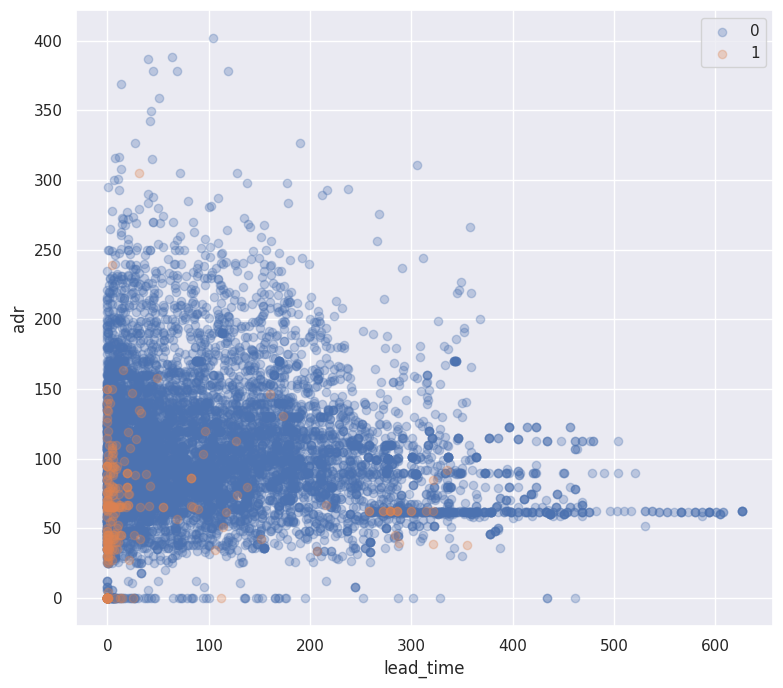

In [33]:
create_scatter(df_hotels_train, "lead_time", "adr", "is_repeated_guest", 0.15)

Se aprecia que la mayoria de los huespedes actuales no tuvo reservas anteriores, independientemente del hotel.

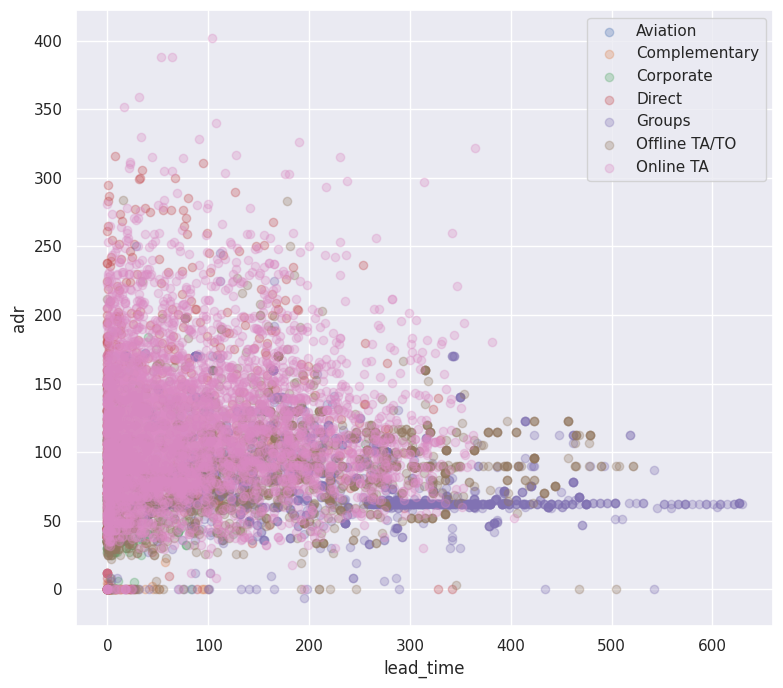

In [34]:
create_scatter(df_hotels_train, "lead_time", "adr", "market_segment", 0.15)

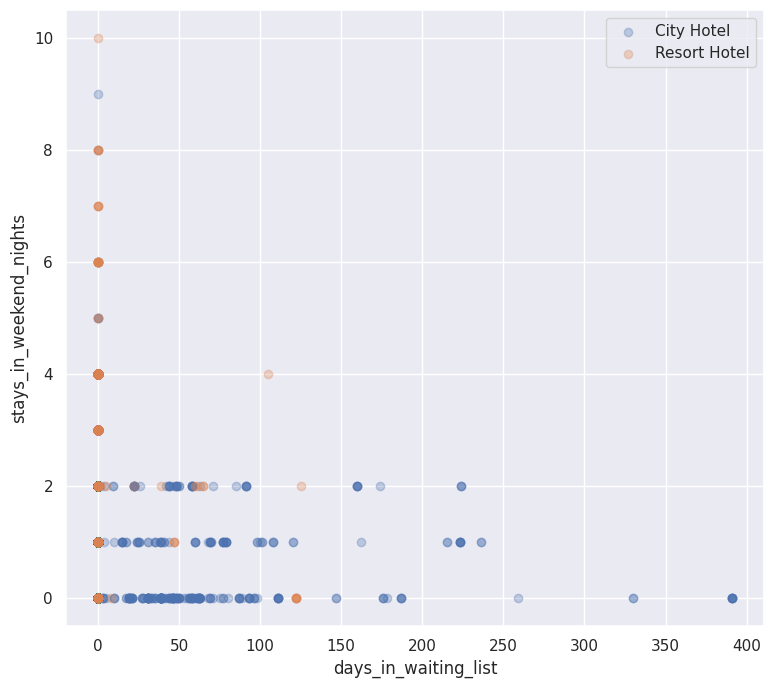

In [35]:
create_scatter(df_hotels_train, "days_in_waiting_list", "stays_in_weekend_nights", "hotel", 0.15)

Para el City Hotel, hay mas reservas en lista de espera, pero en el Resort Hotel hay mas estadias que abarcan varios fines de semana.

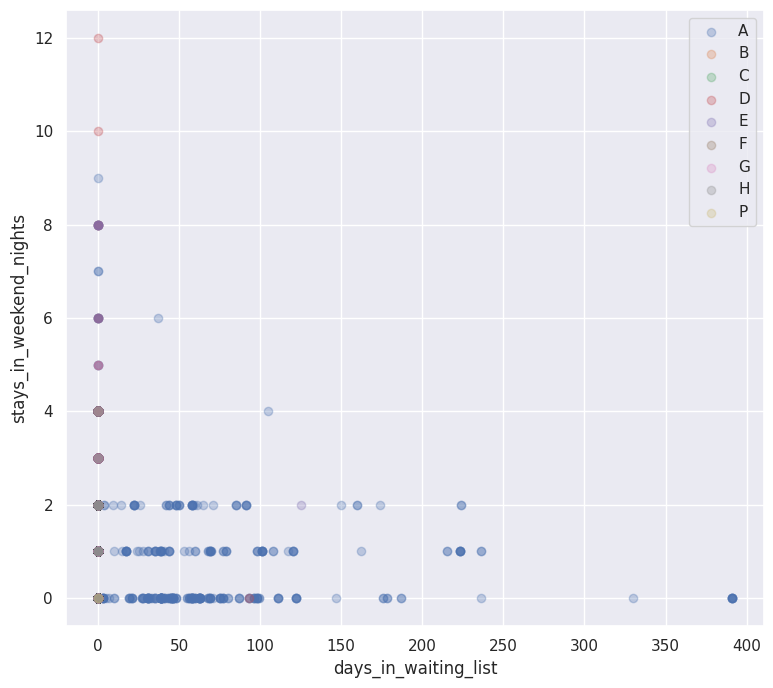

In [36]:
create_scatter(df_hotels_train, "days_in_waiting_list", "stays_in_weekend_nights", "reserved_room_type", 0.15)

El room type A es el que mas figura en las listas de espera.

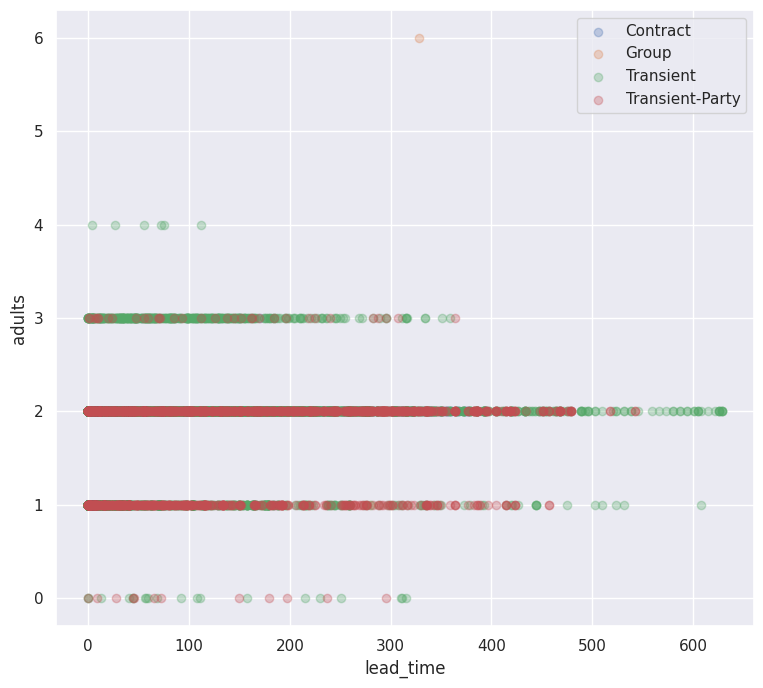

In [37]:
create_scatter(df_hotels_train, "lead_time", "adults", "customer_type", 0.15)

Most customer types are Transient and Transient-Party.

## Relaciones variables categóricas

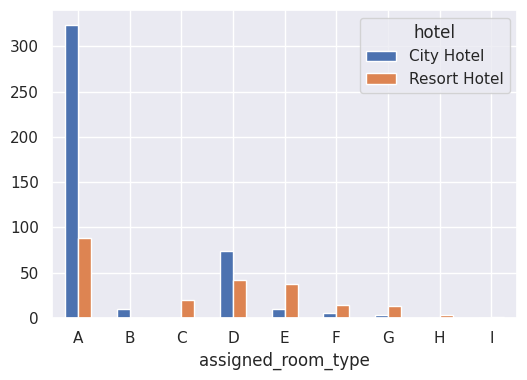

In [38]:
create_xtab_barplot(df_hotels_train, "assigned_room_type", "hotel", sample_pct=0.1)

Es mas probable que las habitaciones A, B, D, F y K sean asignadas en el City Hotel. Las C, E, G, H e I en el Resort Hotel.

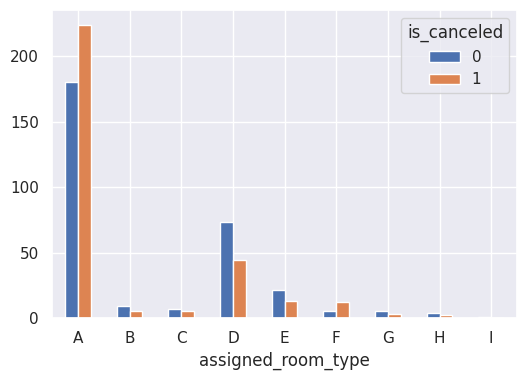

In [39]:
create_xtab_barplot(df_hotels_train, "assigned_room_type", "is_canceled", sample_pct=0.1)

Es mas probable que la reserva sea cancelada si se asigno una habitacion de tipo A.

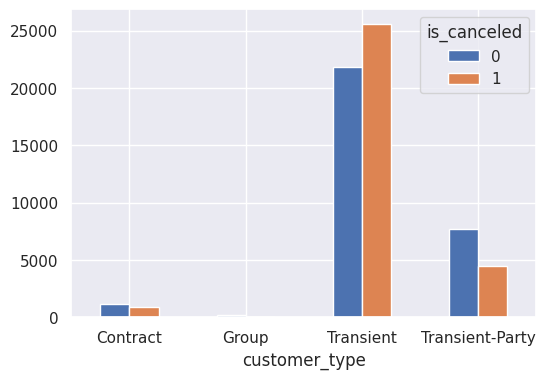

In [40]:
create_xtab_barplot(df_hotels_train, "customer_type", "is_canceled")

Si el tipo de huesped es Transient, entonces es mas probable que cancele la reserva respecto a los demas tipos de huesped.

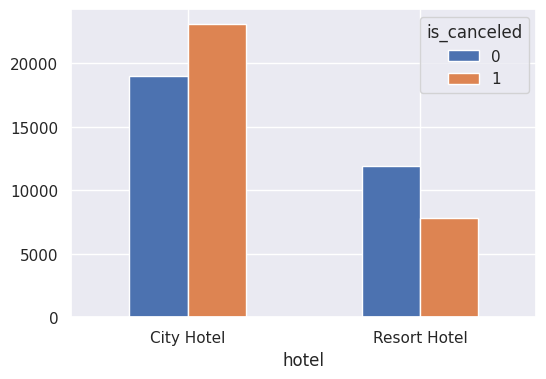

In [41]:
create_xtab_barplot(df_hotels_train, "hotel", "is_canceled")

Es mas probable que la reserva sea cancelada para el City Hotel que para el Resort Hotel

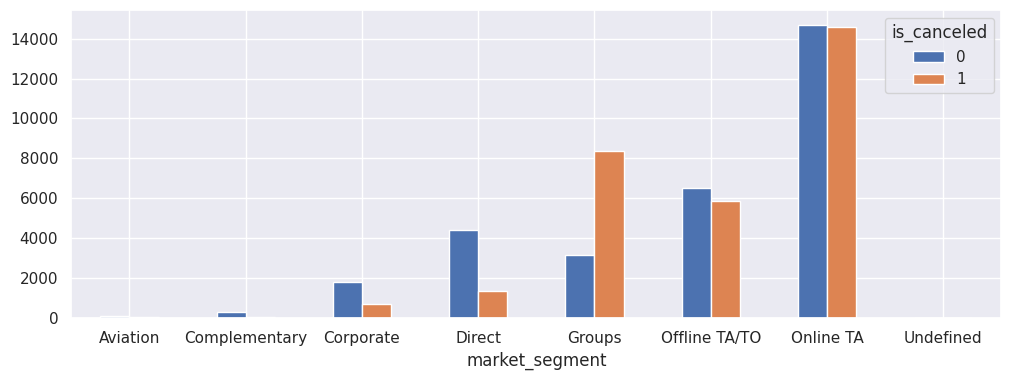

In [42]:
create_xtab_barplot(df_hotels_train, "market_segment", "is_canceled", (12,4))

Es mas probable que la reserva sea cancelada para Groups market segment.

##Datos Faltantes

Analizar la presencia de datos faltantes en el dataset

In [43]:
datos_faltantes = df_hotels_train.isnull().sum()
print(datos_faltantes)

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             221
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              7890
company                           58761
days_in_waiting_list                  0


Obeservamos que en las columnas de: country, children, agent y company tenemos datos faltantes (por datos faltantes nos referimos a los datos que aparecen como NaN)

Realizamos los graficos correspondientes a dichos datos faltantes

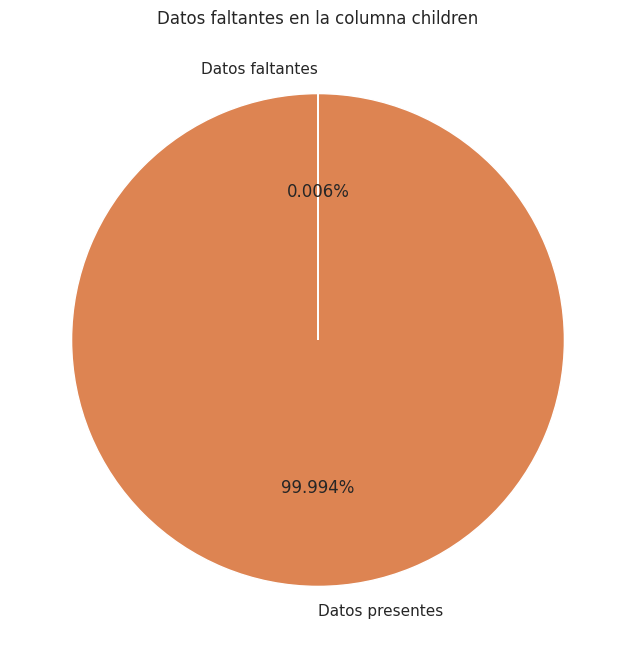

In [44]:
datos_faltantes = df_hotels_train['children'].isnull().sum()

labels = ['Datos faltantes', 'Datos presentes']
sizes = [datos_faltantes, len(df_hotels_train) - datos_faltantes]
plt.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90)

plt.title('Datos faltantes en la columna children')

plt.show()




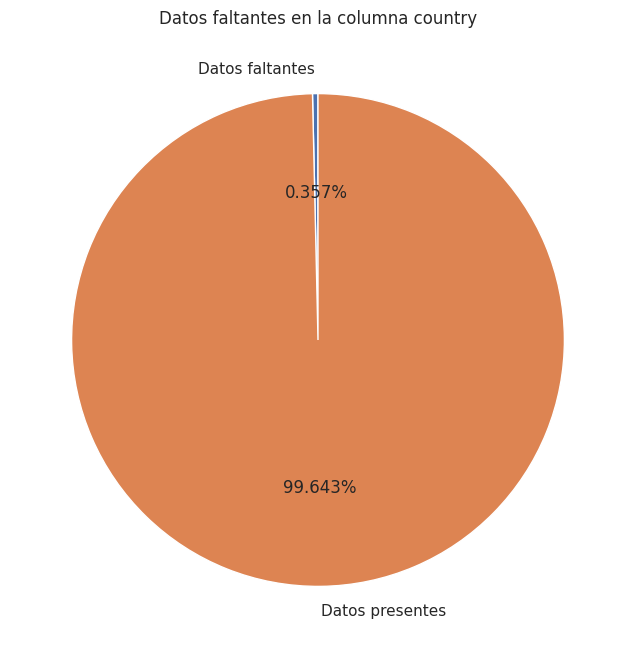

In [45]:
datos_faltantes = df_hotels_train['country'].isnull().sum()

labels = ['Datos faltantes', 'Datos presentes']
sizes = [datos_faltantes, len(df_hotels_train) - datos_faltantes]
plt.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90)

plt.title('Datos faltantes en la columna country')

plt.show()

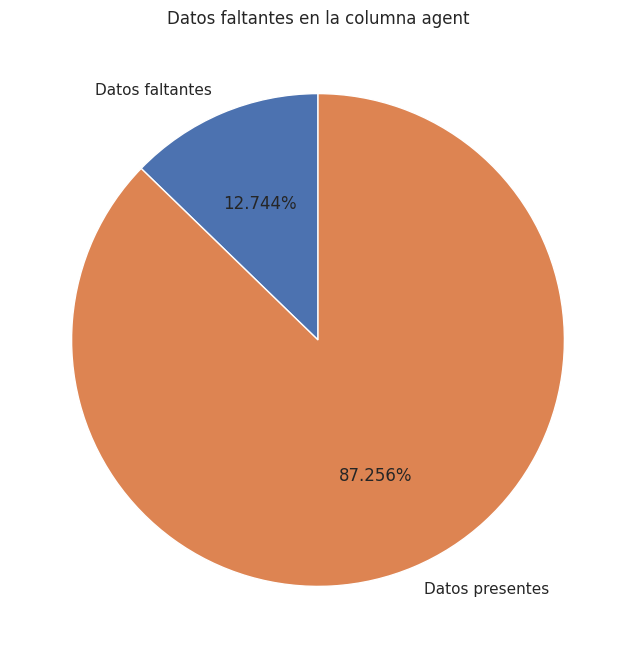

In [46]:
datos_faltantes = df_hotels_train['agent'].isnull().sum()

labels = ['Datos faltantes', 'Datos presentes']
sizes = [datos_faltantes, len(df_hotels_train) - datos_faltantes]
plt.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90)

plt.title('Datos faltantes en la columna agent')

plt.show()

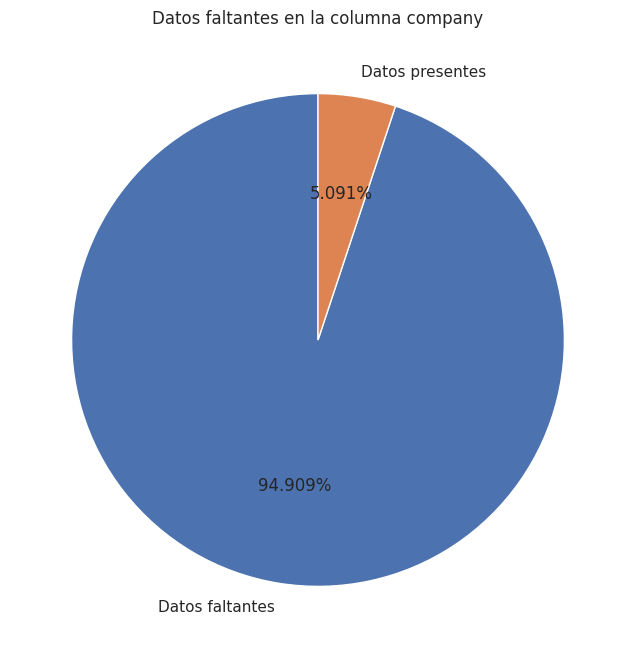

In [47]:
datos_faltantes = df_hotels_train['company'].isnull().sum()

labels = ['Datos faltantes', 'Datos presentes']
sizes = [datos_faltantes, len(df_hotels_train) - datos_faltantes]
plt.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90)

plt.title('Datos faltantes en la columna company')

plt.show()

Decision sobre los datos faltantes 

La columna company tiene una cantidad de datos faltantes demasiado alto, por lo tanto tenemos poca informacion sobre dicha columna.
Por lo que procederemos a eliminar esta columna

In [48]:
#Eliminacion de company
df_hotels_train = df_hotels_train.drop(['company'], axis =1)

Las columnas children, agent y country tienen una cantidad mucho menor de datos faltantes (en el caso de agent la que tiene el porcentaje da datos faltantes mas alto) no nos parece bien eliminarlas, entonces vamos a tomar una moda y rellenarlas.
Tomaremos el valor que mas se repite como moda y lo usaremos para rellenas las ccolumnas de datos faltantes
Esta decision se debe a que conocemos bastante de dichas columnas, por lo tanto la decision mas acertada nos parece reemplazar los datos.

In [49]:
#Country
df_hotels_train['country'].fillna('PRT', inplace=True)

In [50]:
#Children
df_hotels_train['children'].fillna(0, inplace=True)

In [51]:
#Agent
df_hotels_train['agent'].fillna(9.0, inplace=True)

In [52]:
datos_despues_de_rellenarlos = df_hotels_train.isnull().sum()
print(datos_despues_de_rellenarlos)

hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

Vemos que despues de realizar las imputaciones de los datos (y la eliminacion de company) no tenemos datos faltantes en nuestro dataset

Graficos una vez realizada las imputaciones

In [53]:
#Children
data_chicos = df_hotels_train[['children']].groupby(['children'])['children'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_chicos.columns = ['Chicos','Cantidad']

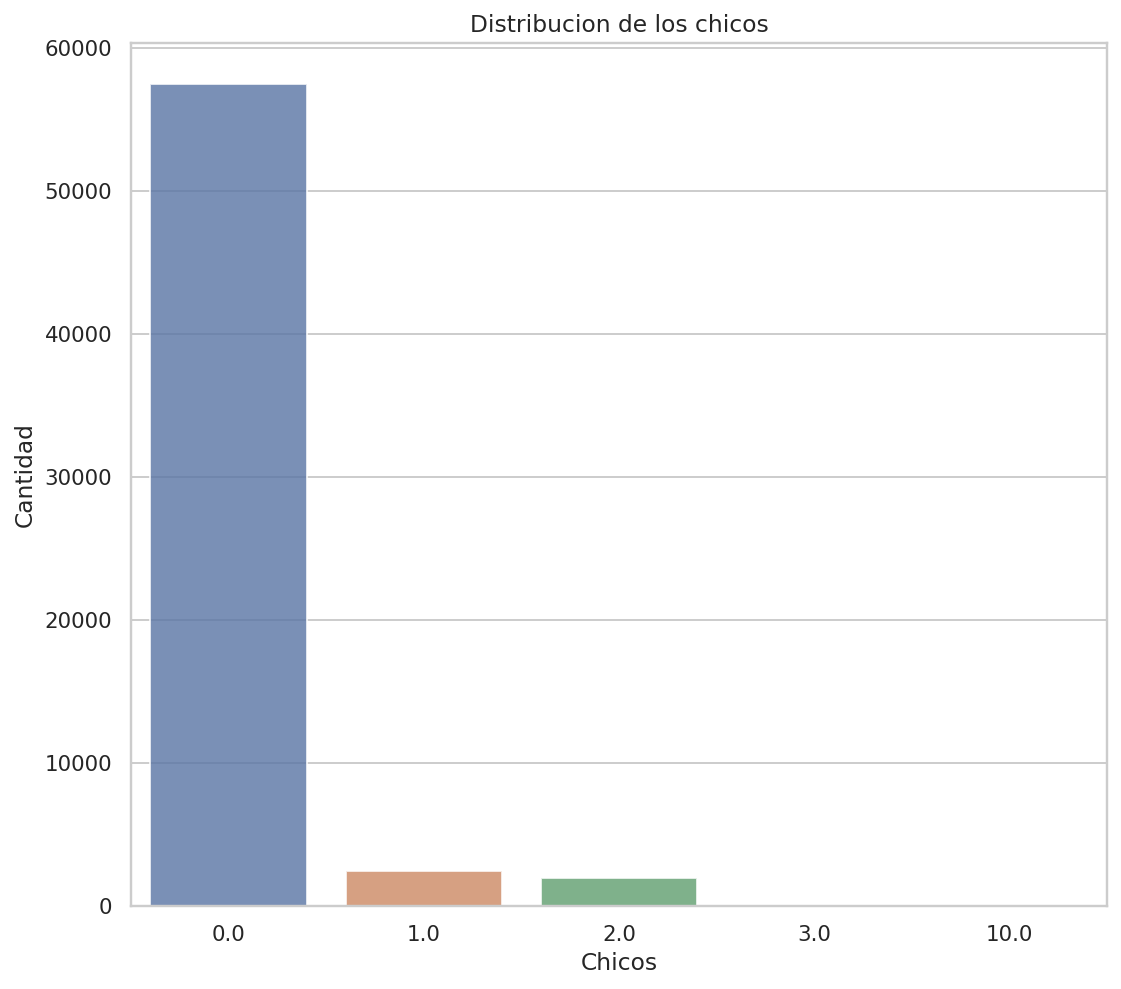

In [54]:
crear_bar_plot(data_chicos.head(25),'Chicos','Cantidad','Distribucion de los chicos')

La variable children no tiene cambios en su grafico (debido a que tenemos un porcentaje bajisimo de datos faltantes)

In [55]:
data_paises = df_hotels_train[['country']].groupby(['country'])['country'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_paises.columns = ['Pais','Cantidad']

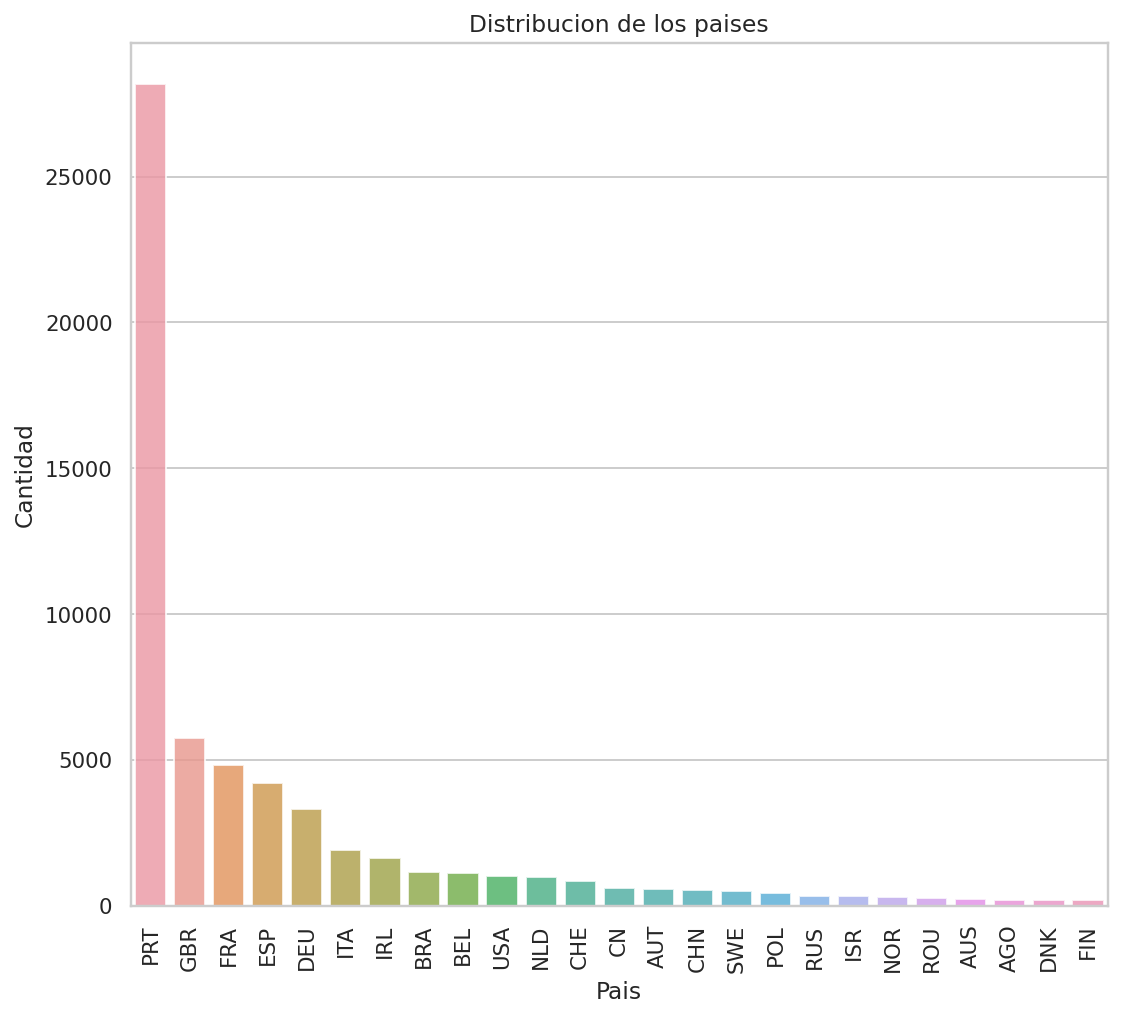

In [56]:
#Countrys
crear_bar_plot(data_paises.head(25),'Pais','Cantidad','Distribucion de los paises')

Como vemos en el grafico, no notamos un incremento en paises, debido a que los datos faltantes tambien es muy bajo como para notar una alteracion en la distribucion de datos

In [57]:
#Agentes
data_agentes = df_hotels_train[['agent']].groupby(['agent'])['agent'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)
data_agentes.columns = ['Agente','Cantidad']

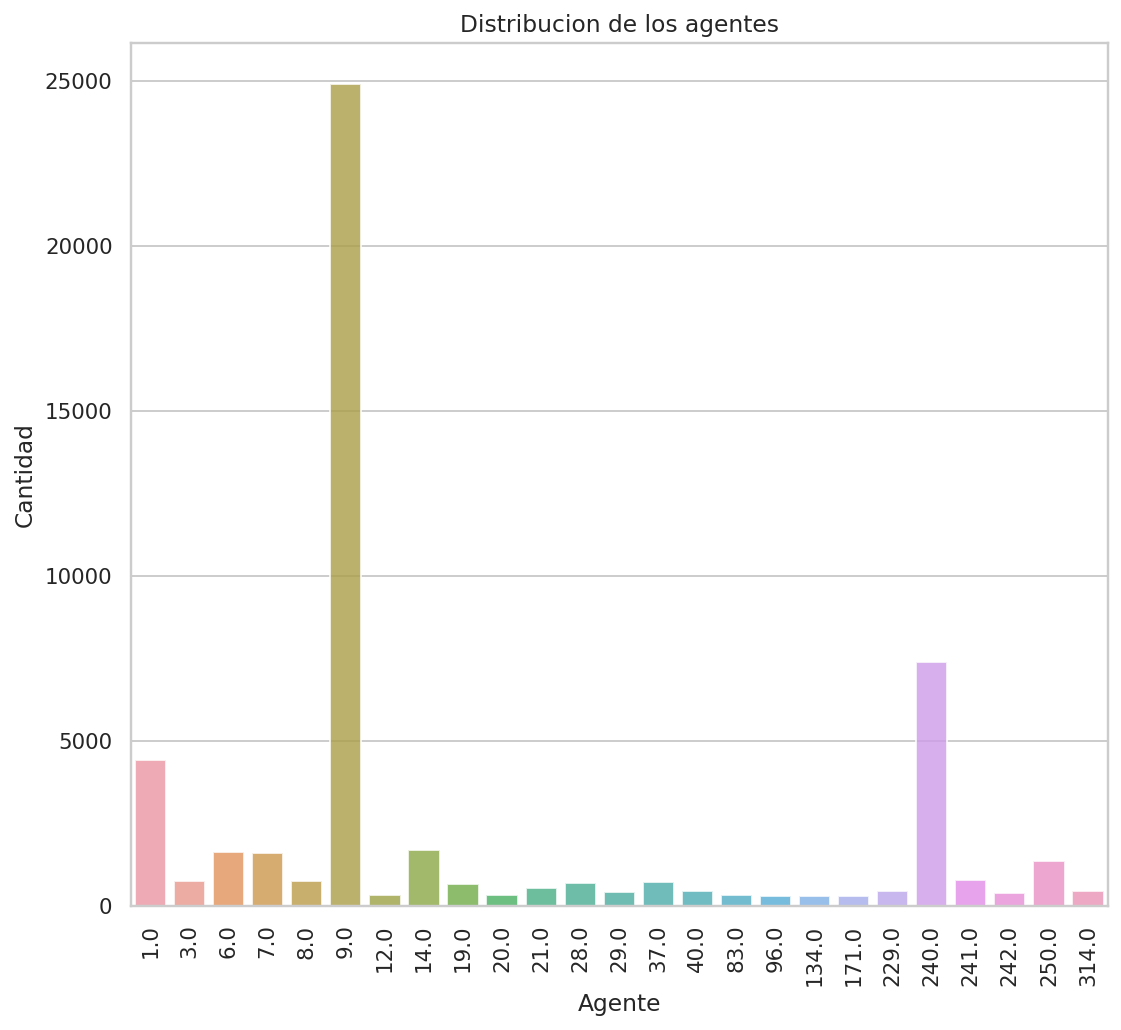

In [58]:
crear_bar_plot(data_agentes.head(25),'Agente','Cantidad','Distribucion de los agentes')

Como vemos en en esa distribucion, si notamos un gran cambio de acuerdo a la original ya que el agent 9.0 pasa de tener 16 mil a casi 25 mil.
Era de esperarse, ya que rellenamos una gran parte del dataset, por lo tanto la distribucion tenia que subir.

Ejecutamos nuevamente el groupby y volvemos a sumar las variables, ya que como imputamos mas datos necesitamos ver los cambios que se realizan en los graficos.
El unico cambio notorio lo tenemos en la variable agent.